# PV3 Comparison of hourly data

<img src="http://reiner-lemoine-institut.de//wp-content/uploads/2015/09/rlilogo.png" width="100" style="float: right">

__copyright__ 	= "© Reiner Lemoine Institut" <br>
__license__ 	= "GNU Affero General Public License Version 3 (AGPL-3.0)" <br>
__url__ 		= "https://www.gnu.org/licenses/agpl-3.0.en.html" <br>
__author__ 		= "Ludwig Hülk" <br>

# Imports

In [1]:
import sys
import os
import getpass
import pandas as pd
import numpy as np
import json
from sqlalchemy import *
# plot
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.graph_objs as go
import plotly.offline as pltly
import colorlover as cl
import seaborn as sns
# notebook
from IPython.display import Image
from IPython.core.display import HTML 

pltly.init_notebook_mode(connected=True)
%matplotlib inline

version = 'v1 (jupyter)'
project = 'pv3'

# Database Connection

In [2]:
def postgres_session():
    """SQLAlchemy session object with valid connection to reeem database"""
    
    print('Please provide connection parameters to database:\n' +
              'Hit [Enter] to take defaults')
    host = 'localhost' # input('host (default 130.226.55.43): ')
    port = '5434' # input('port (default 5432): ')
    database = 'sonnja_db' # input("database name (default 'reeem'): ")
    user = 'sonnja' # input('user (default postgres): ')
    # password = input('password: ')
    password = getpass.getpass(prompt='password: ',
                                   stream=sys.stderr)
    con = create_engine(
            'postgresql://' + '%s:%s@%s:%s/%s' % (user,
                                                  password,
                                                  host,
                                                  port,
                                                  database)).connect()
    print('Password correct! Database connection established.')
    return con

# start session
con = postgres_session()

D:\Anaconda3\envs\d_py37_vis\lib\site-packages\ipykernel_launcher.py:12: UserWarning:

The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel



Please provide connection parameters to database:
Hit [Enter] to take defaults
password: ········
Password correct! Database connection established.


# Data Analysis

## Select table metadata

This section can be used to get the metadata from one database table.<br>
The result is printed.<br>

In [3]:
# Database select (SQL)
sql = text("""SELECT obj_description('pv3.einleuchtend_wrdata_2015_wr1'::regclass);""")
meta_str = pd.read_sql_query(sql, con).loc[0, 'obj_description']
print(meta_str)

{
    "title": "einleuchtend e.V. inverter 1 (WR1)",
    "description": "SonnJa! measurement data",
    "language": [ "eng" ],
    "sources": [
        {"name": "einleuchtend e.V.", 
        "description": "SonnJa! measurement data", 
        "url": "http://einleuchtend.org/sonn-ja/daten-fakten/", 
        "license": "none", 
        "copyright": "© einleuchtend e.V."} ],
    "spatial": [
        {"location": "52.455778° N, 13.523917° O",
        "extent": "none",
        "resolution": "none"} ],
    "temporal": [
        {"reference_date": "none",
        "start": "2015-01-01",
        "end": "2015-31-12",
        "resolution": "minute"} ],
    "license": [
        {"id": "none",
        "name": "none",
        "version": "none",
        "url": "none",
        "instruction": "For scientific purposes and teaching only!",
        "copyright": "© einleuchtend e.V."} ],
    "contributors": [
        {"name": "Ludwig Hülk", "email": "none", "date": "2017-06-14", "comment": "Create metadata

In [4]:
text_name = r'data/einleuchtend_wrdata_2015_wr1_metadata.txt'
with open(text_name, "w") as text_file:
    print(meta_str, file=text_file)
print("Metadata saved to file:", text_name)

Metadata saved to file: data/einleuchtend_wrdata_2015_wr1_metadata.txt


In [5]:
# Database select (SQL)
sql = text("""SELECT obj_description('pv3.htw_weatherdata_2015'::regclass);""")
meta_str = pd.read_sql_query(sql, con).loc[0, 'obj_description']
print(meta_str)

{
    "title": "HTW Weatherdata 2015",
    "description": "Weatherdata for 2015 with minute resolution",
    "language": [ "eng" ],
    "sources": [
        {"name": "HTW Wetterstation", 
        "description": "Wetterstation der Hochschule für Technik und Wirtschaft Berlin (HTW Berlin)", 
        "url": "http://wetter.htw-berlin.de",
        "license": "none", 
        "copyright": "© 2017 - wetter.htw-berlin.de"} ],
    "spatial": [
        {"location": "52.455778° N, 13.523917° O",
        "extent": "none",
        "resolution": "none"} ],
    "temporal": [
        {"reference_date": "none",
        "start": "2015-01-01",
        "end": "2015-31-12",
        "resolution": "minute"} ],
    "license": [
        {"id": "none",
        "name": "none",
        "version": "none",
        "url": "none",
        "instruction": "none",
        "copyright": "© 2017 - wetter.htw-berlin.de"} ],
    "contributors": [
        {"name": "Ludwig Hülk", "email": "none", "date": "2017-06-14", "comment

In [6]:
text_name = r'data/htw_weatherdata_2015.txt'
with open(text_name, "w") as text_file:
    print(meta_str, file=text_file)
print("Metadata saved to file:", text_name)

Metadata saved to file: data/htw_weatherdata_2015.txt


## Select raw data

Requires script: htw_pv3_postgresql_06_data_join.sql

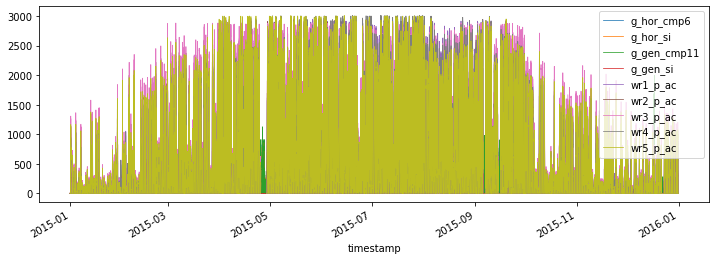

In [17]:
# Database select (SQL)
sql = text("""
    SELECT  timestamp, g_hor_cmp6, g_hor_si, g_gen_cmp11, g_gen_si, wr1_p_ac, wr2_p_ac, wr3_p_ac, wr4_p_ac, wr5_p_ac   -- column
    FROM    pv3.pv3_time_sun_weather_allwr_2015_mview  -- table
    """)
df_raw = pd.read_sql_query(sql, con)
df_raw = df_raw.set_index('timestamp')
ax = df_raw.plot(figsize=(12, 4), lw=0.75)

### Resample to 1 hour

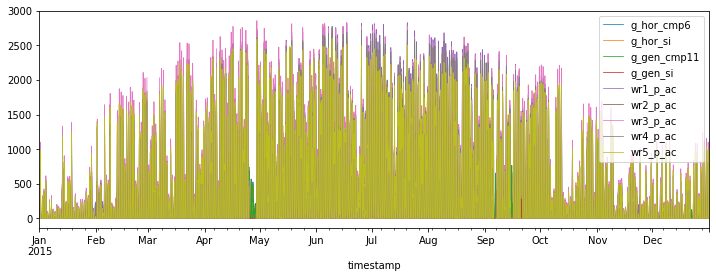

In [18]:
df_raw_reH = df_raw.resample('1H').mean()
ax = df_raw_reH.plot(figsize=(12, 4), lw=0.75)

## Select calculated data

Requires script: htw_pv3_postgresql_08_calculations.sql

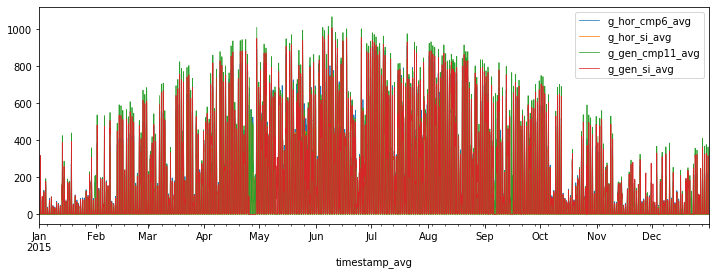

In [19]:
# Database select (SQL)
sql = text("""
    SELECT  timestamp_avg, g_hor_cmp6_avg, g_hor_si_avg, g_gen_cmp11_avg, g_gen_si_avg -- column
    FROM    pv3.pv3_time_weather_2015_hourly_mview  -- table
    """)
df_calc_w = pd.read_sql_query(sql, con)
df_calc_w = df_calc_w.set_index('timestamp_avg')
ax = df_calc_w.plot(figsize=(12, 4), lw=0.75)

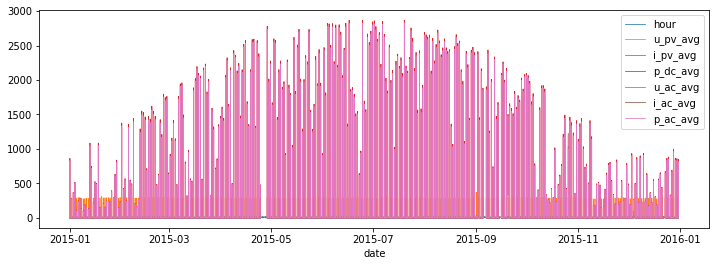

In [24]:
# Database select (SQL)
sql = text("""
    SELECT  date, hour, u_pv_avg, i_pv_avg, p_dc_avg, u_ac_avg, i_ac_avg, p_ac_avg
    FROM    pv3.pv3_time_wr1_2015_hourly_mview  -- table
    """)
df_calc_wr1 = pd.read_sql_query(sql, con)
df_calc_wr1 = df_calc_wr1.set_index('date', 'hour')
ax = df_calc_wr1.plot(figsize=(12, 4), lw=0.75)

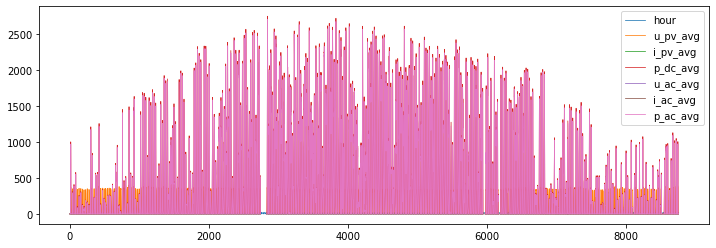

In [32]:
# Database select (SQL)
sql = text("""
    SELECT  date, hour, u_pv_avg, i_pv_avg, p_dc_avg, u_ac_avg, i_ac_avg, p_ac_avg
    FROM    pv3.pv3_time_wr2_2015_hourly_mview  -- table
    """)
df_calc_wr2 = pd.read_sql_query(sql, con)
ax = df_calc_wr2.plot(figsize=(12, 4), lw=0.75)

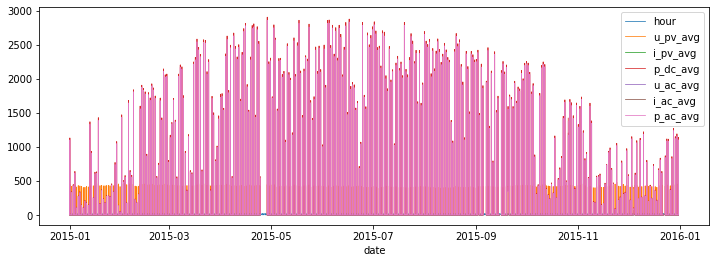

In [27]:
# Database select (SQL)
sql = text("""
    SELECT  date, hour, u_pv_avg, i_pv_avg, p_dc_avg, u_ac_avg, i_ac_avg, p_ac_avg
    FROM    pv3.pv3_time_wr3_2015_hourly_mview  -- table
    """)
df_calc_wr3 = pd.read_sql_query(sql, con)
df_calc_wr3 = df_calc_wr3.set_index('date', 'hour')
ax = df_calc_wr3.plot(figsize=(12, 4), lw=0.75)

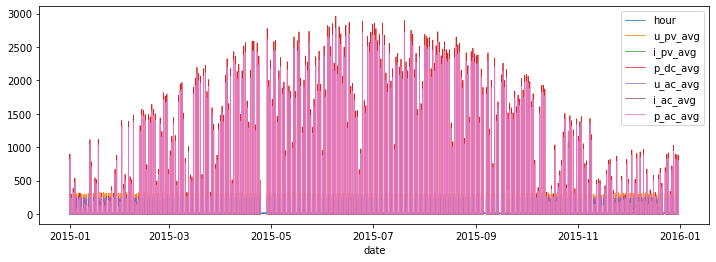

In [28]:
# Database select (SQL)
sql = text("""
    SELECT  date, hour, u_pv_avg, i_pv_avg, p_dc_avg, u_ac_avg, i_ac_avg, p_ac_avg
    FROM    pv3.pv3_time_wr4_2015_hourly_mview  -- table
    """)
df_calc_wr4 = pd.read_sql_query(sql, con)
df_calc_wr4 = df_calc_wr4.set_index('date', 'hour')
ax = df_calc_wr4.plot(figsize=(12, 4), lw=0.75)

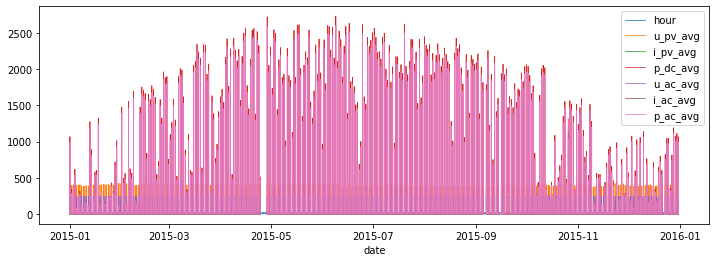

In [29]:
# Database select (SQL)
sql = text("""
    SELECT  date, hour, u_pv_avg, i_pv_avg, p_dc_avg, u_ac_avg, i_ac_avg, p_ac_avg
    FROM    pv3.pv3_time_wr5_2015_hourly_mview  -- table
    """)
df_calc_wr5 = pd.read_sql_query(sql, con)
df_calc_wr5 = df_calc_wr5.set_index('date', 'hour')
ax = df_calc_wr5.plot(figsize=(12, 4), lw=0.75)

# Metadata

The important information from the above select (**df**) is collected in a Dictionary (**info_dict**).

In [30]:
# Facts dict
info_dict = {}
info_dict['Filename'] = ['{}_pv3_sonnja_plot_all_wr_hourly'.format(pd.to_datetime('today').strftime("%Y-%m-%d"))]
info_dict['Value'] = ['Leistung (P_AC)']
info_dict['Unit'] = ['W']
info_dict['Y-Axis'] = ['{} in {}'.format(*info_dict['Value'], *info_dict['Unit'])]
info_dict['X-Axis'] = ['Stunde im Jahr']
info_dict['Title'] = ['Alle Wechselrichter']
info_dict['Metadata'] = [meta_str]

# Print facts
# for x in info_dict:
#     print(x,':',info_dict[x])

## Interactive Plot with Metadata

In [33]:
# Interactive plot
data = [
    go.Scatter(x=df_raw_reH.index.tolist(), 
               y=df_raw_reH['wr1_p_ac'].tolist(), 
               name='WR1-hour-py', line=dict(), mode='lines'),
    go.Scatter(x=df_calc_wr1.index.tolist(), 
               y=df_calc_wr1['p_ac_avg'].tolist(), 
               name='WR1-hour-avg', line=dict(), mode='lines')
]
layout = go.Layout(
    title=''.join(info_dict['Title']),
    yaxis=dict(title=''.join(info_dict['Y-Axis'])),
    xaxis=dict(title=''.join(info_dict['X-Axis']))
)
fig = go.Figure(data=data, layout=layout)
pltly.iplot(fig)

### One WR

In [ ]:
# Interactive plot
sns.set_style('ticks')
trace_line = go.Scatter(x=df_reD.index.tolist(), 
                        y=df_reD['wr1_p_ac'].tolist(), 
                        name='WR1 täglich', line=dict(), mode='lines')
trace_bar = go.Bar(x=df_reM.index.tolist(), 
                   y=df_reM['wr1_p_ac'].tolist(), 
                   name='WR1 monatlich', marker=dict())
layout = go.Layout(
    title=''.join(info_dict['Title']),
    yaxis=dict(title=''.join(info_dict['Y-Axis'])),
    xaxis=dict(title=''.join(info_dict['X-Axis']))
)
ifig = go.Figure(data=[trace_bar, trace_line], layout=layout)
pltly.iplot(ifig)

## Save results to files

The results are saved to cooresponding files in a folder named **data**.<br>
The **info_dict** is saved to a text file (txt).<br>
The **data** is saved to a table (csv).<br>
The **plot** is saved as an image (png).<br>
The **interactive plot** is saved as a webpage (html). It will also open in a new tab of your browser.

In [ ]:
# Write facts to textfile
txtname = ('data/{}.txt').format(*info_dict['Filename'])
with open(txtname,'w') as tfile:
    for i in info_dict.keys():
        tfile.write(i + ": " + ', '.join([str(x) for x in info_dict[i]]) + "\n")
tfile.close()
print("Facts saved to file:", txtname)

# Save data to CSV
csvname = 'data/{}.csv' .format(*info_dict['Filename'])
df_reH.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save plot as file
plotname = 'data/{}.png' .format(*info_dict['Filename'])
mfig.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

# Save interactive plot
htmlname = 'data/{}.html' .format(*info_dict['Filename'])
pltly.plot(ifig, filename=htmlname)
print("Interactive plot saved to file:", htmlname)